<a href="https://colab.research.google.com/github/JonasRiber/Dl_project_HAM10000/blob/main/anders_ny.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Import data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd


data = pd.read_csv("/content/drive/My Drive/archive/hmnist_28_28_RGB.csv")
data.head()
meta_df = pd.read_csv("/content/drive/My Drive/archive/HAM10000_metadata.csv")
meta_df.head()


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


##Inspect data

In [ ]:
## chaking the shape of our data

print(meta_df.shape)
print(data.shape)



(10015, 7)
(10015, 2353)


In [ ]:
### cheking the distrobution of the data in each class
yData = data['label']
XData = data.drop(columns = ['label'])
# EDA
distribution = meta_df['dx'].value_counts()
distribution
# classes = {4: ('nv', ' Nevus'),
#            6: ('mel', 'Melanoma'),
#            2 :('bkl', 'Seborrheic Keratosis'),
#            1:('bcc' , ' Basal Cell Carcinoma '),
#            5: ('vasc', 'Vascular Lesion'),
#            0: ('akiec', 'Actinic Keratosis'),
#            3: ('df', 'Dermatofibroma')}

,count
dx,
nv,6705
mel,1113
bkl,1099
bcc,514
akiec,327
vasc,142
df,115


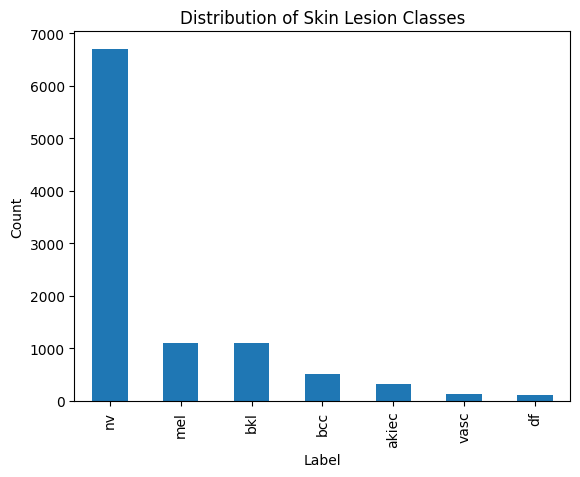

In [ ]:
# Create the histogram
distribution.plot(kind='bar')  # Use kind='bar' for a histogram
plt.title('Distribution of Skin Lesion Classes')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

## oversample

In [ ]:

# Fixing Data Imbalance
from imblearn.over_sampling import RandomOverSampler #makes batch with we replacement to make it balanced
# 1. Initialize RandomOverSampler
sampler = RandomOverSampler()
# 2. Perform Oversampling
XData,yData  = sampler.fit_resample(XData,yData)
XData.shape, yData.shape
# 3. Reshape and Normalize
XData = np.array(XData).reshape((-1, 28, 28, 3))
XData = XData / 255
XData.shape



(46935, 28, 28, 3)

##Data Argumentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Import ImageDataGenerator


# Initialize the ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rotation_range=20,      # Random rotation
    width_shift_range=0.2,  # Random width shift
    height_shift_range=0.2, # Random height shift
    shear_range=0.2,        # Random shear
    zoom_range=0.2,         # Random zoom
    horizontal_flip=True,   # Random horizontal flip
    fill_mode='nearest'     # Filling mode for new pixels
)

# Create a generator that augments images
augmented_images = []
augmented_labels = []

# Generate augmented images
for i in range(len(XData)):
    img = np.expand_dims(XData[i], axis=0)  # Expand dimensions to fit the generator
    for batch in datagen.flow(img, batch_size=1):
        augmented_images.append(batch[0])
        augmented_labels.append(yData[i])

# Convert lists to NumPy arrays
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)


KeyboardInterrupt: 

## undersampling


In [ ]:
from imblearn.under_sampling import RandomUnderSampler
import numpy as np

# 1. Initialize RandomUnderSampler
sampler = RandomUnderSampler()

# 2. Perform Undersampling
XData, yData = sampler.fit_resample(XData, yData)

# 3. Reshape and Normalize
XData = np.array(XData).reshape((-1, 28, 28, 3))
XData = XData / 255.0

XData.shape, yData.shape

ValueError: Found array with dim 4. None expected <= 2.

## create the train and validation set

In [ ]:

# Creating the train and validation set
from sklearn.model_selection import train_test_split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(XData,yData, test_size=0.2)
Xtrain.shape, Xtest.shape



((37548, 28, 28, 3), (9387, 28, 28, 3))

## Import Functions


In [ ]:


import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dense, Dropout, Activation
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D, SeparableConv2D
from tensorflow.keras.layers import Conv2DTranspose, ZeroPadding2D, SpatialDropout2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input

input_shape = (28, 28, 3)
num_classes = 7



## resnet 50

In [ ]:
### resize
Xtrain_resized = tf.image.resize(Xtrain, (32, 32))
Xtest_resized = tf.image.resize(Xtest, (32, 32))

In [ ]:


from tensorflow.keras.applications import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(7, activation='softmax')(x)

Resnet = Model(inputs=base_model.input, outputs=predictions)

Resnet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])



In [ ]:
history = Resnet.fit(Xtrain_resized, Ytrain,
                           validation_data=(Xtest_resized, Ytest),
                           epochs=5)

Epoch 1/5
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 127s 56ms/step - accuracy: 0.5491 - loss: 1.4345 - val_accuracy: 0.6857 - val_loss: 0.8472
Epoch 2/5
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - accuracy: 0.7939 - loss: 0.5875 - val_accuracy: 0.8296 - val_loss: 0.4563
Epoch 3/5
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 39s 33ms/step - accuracy: 0.8617 - loss: 0.3819 - val_accuracy: 0.7906 - val_loss: 0.6782
Epoch 4/5
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 42s 34ms/step - accuracy: 0.8887 - loss: 0.3145 - val_accuracy: 0.5213 - val_loss: 1.7146
Epoch 5/5
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - accuracy: 0.8322 - loss: 0.4995 - val_accuracy: 0.6705 - val_loss: 0.9998


In [ ]:
from tabulate import tabulate

loss_resnet, accuracy_resnet = Resnet.evaluate(Xtest_resized, Ytest)

table = [["\033[1mTest Accuracy\033[0m", "{:.2f}%".format(accuracy_resnet * 100)],
         ["\033[1mTest Loss\033[0m", "{:.4f}".format(loss_resnet)]]

print(tabulate(table, tablefmt="grid"))

294/294 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6683 - loss: 1.0053
+---------------+--------+
| Test Accuracy | 67.05% |
+---------------+--------+
| Test Loss     | 0.9998 |
+---------------+--------+


294/294 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step

Classification Report
              precision    recall  f1-score   support

           0       0.92      0.36      0.51      1346
           1       0.61      0.82      0.70      1323
           2       0.55      0.73      0.63      1324
           3       0.88      0.91      0.90      1386
           4       0.47      0.83      0.60      1354
           5       0.89      0.94      0.91      1301
           6       0.89      0.11      0.20      1353

    accuracy                           0.67      9387
   macro avg       0.75      0.67      0.64      9387
weighted avg       0.75      0.67      0.64      9387



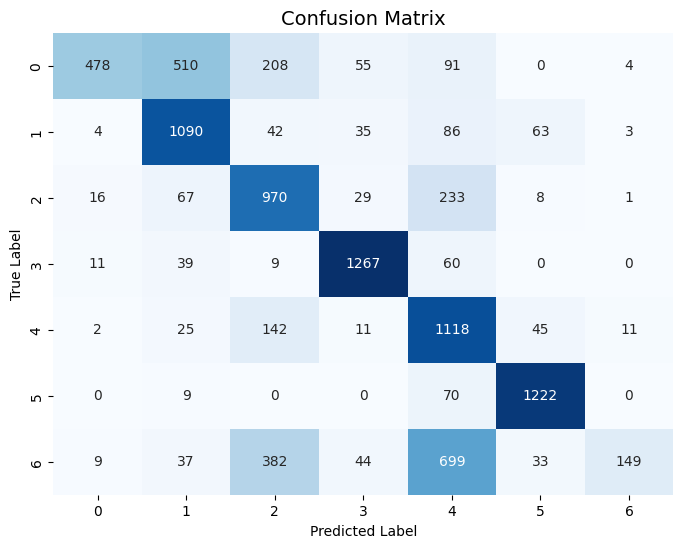

In [ ]:


from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

Ypred_resnet50 = Resnet.predict(Xtest_resized)
Ypred_resnet50 = Ypred_resnet50.argmax(axis=1)



print("\n\033[1mClassification Report\033[0m")
print(classification_report(Ytest, Ypred_resnet50))


conf_matrix = confusion_matrix(Ytest, Ypred_resnet50)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix", fontsize=14)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


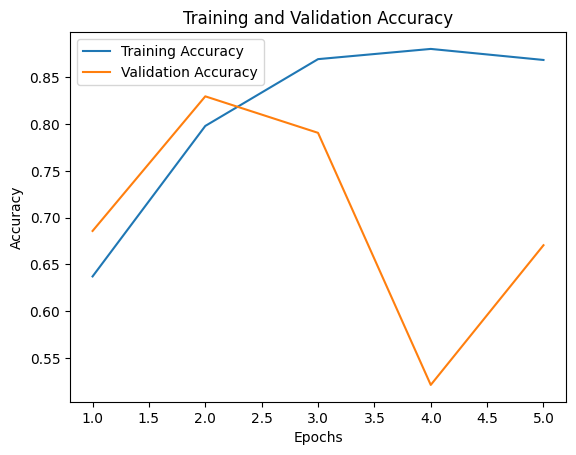

In [ ]:


import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(range(1, len(train_acc) + 1), train_acc, label='Training Accuracy')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



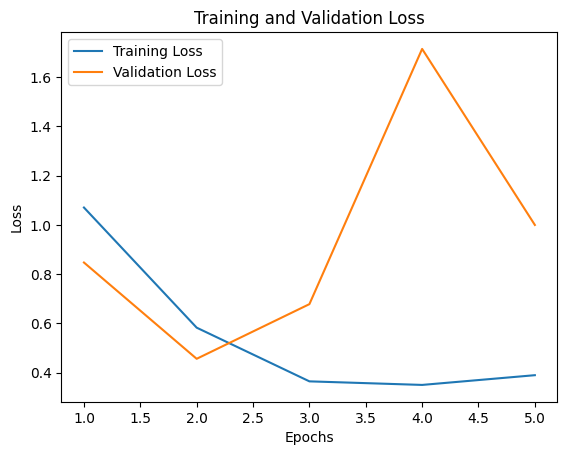

In [ ]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()